## Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.cluster import KMeans
from mlxtend import plotting 
from sklearn.neighbors import NearestCentroid

%matplotlib inline

## DF loading

In [2]:
initial_df = pd.read_csv("insurance.csv")
initial_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### one hot encoding

In [3]:
# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

In [4]:
# sprawdzenie
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.900,0,16884.92400,0,1,0,0,1,0,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0,1,0
1334,18,31.920,0,2205.98080,0,0,0,0,0,1,0
1335,18,36.850,0,1629.83350,0,0,0,1,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1,0,0


In [5]:
initial_df['progi'] = 0

In [6]:
df['progi'] = 0

In [93]:
# progi:

IV_opis = '>30000'

III_opis = '15000-30000'
III_prog = 30000

II_prog = 15000
II_opis = '6000-15000'

I_prog = 6000
I_opis = '<6000'

In [95]:
# progi do initial_df (label encoder)

for index, row in initial_df.iterrows():
    if row['charges'] > III_prog:
        initial_df.loc[index,'progi'] = IV_opis
    elif row['charges'] < I_prog:
        initial_df.loc[index,'progi'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        initial_df.loc[index,'progi'] = II_opis
    else:
        initial_df.loc[index,'progi'] = III_opis
        
initial_df.groupby('progi').max()

,age,sex,bmi,children,smoker,region,charges,bmi_cat,age_cat,region_encoded,bmi_cat_encoded,age_cat_encoded,sex_encoded,smoker_encoded
progi,,,,,,,,,,,,,,
15000-30000,64,male,41.91,5,yes,southwest,29523.16560,obesity,elder,3,3,2,1,1
6000-15000,64,male,49.06,5,yes,southwest,14988.43200,obesity,elder,3,3,2,1,1
<6000,42,male,53.13,5,no,southwest,5989.52365,obesity,senior adult,3,3,2,1,0
>30000,64,male,52.58,4,yes,southwest,63770.42801,obesity,elder,3,3,2,1,1


In [96]:
# progi do df

for index, row in df.iterrows():
    if row['charges'] > IV_prog:
        df.loc[index,'progi'] = IV_opis
    elif row['charges'] < I_prog:
        df.loc[index,'progi'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        df.loc[index,'progi'] = II_opis
    else:
        df.loc[index,'progi'] = III_opis
        
df.groupby('progi').mean()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
progi,,,,,,,,,,,
15000-30000,40.045918,28.061454,1.229592,21339.427399,0.489796,0.586735,0.265306,0.280612,0.178571,0.265306,0.005102
6000-15000,48.809437,30.848403,1.248639,10007.927968,0.473684,0.012704,0.250454,0.221416,0.263158,0.537205,0.000000
<6000,26.048951,30.035315,0.808858,3392.999822,0.503497,0.000000,0.247086,0.293706,0.251748,0.489510,0.000000
>30000,40.376543,34.845432,1.166667,40761.308558,0.635802,0.938272,0.179012,0.376543,0.228395,0.919753,0.888889


In [97]:
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
initial_df['bmi_cat'] = pd.cut(x = initial_df['bmi'], bins = [0, 18.5, 24.9, 29.9, 100], labels = ['underweight',
                                                                                  'healthy weight',
                                                                                   'overweight',
                                                                                   'obesity'])

initial_df['age_cat'] = pd.cut(x = initial_df['age'], bins = [0, 35, 56, 100], labels = ['young adult',
                                                                                  'senior adult',
                                                                                   'elder'])


In [98]:
region_numpy = initial_df['region'].to_numpy()
bmi_cat_numpy = initial_df['bmi_cat'].to_numpy()
age_cat_numpy = initial_df['age_cat'].to_numpy()
sex_numpy = initial_df['sex'].to_numpy()
smoker_numpy = initial_df['smoker'].to_numpy()

In [99]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
region_integer_encoded = label_encoder.fit_transform(region_numpy)
bmi_cat_integer_encoded = label_encoder.fit_transform(bmi_cat_numpy)
age_cat_integer_encoded = label_encoder.fit_transform(age_cat_numpy)
#charges_integer_encoded = label_encoder.fit_transform(charges_numpy)
sex_integer_encoded = label_encoder.fit_transform(sex_numpy)
smoker_integer_encoded = label_encoder.fit_transform(smoker_numpy)

In [100]:
initial_df['region_encoded'] = region_integer_encoded
initial_df['bmi_cat_encoded'] = bmi_cat_integer_encoded
initial_df['age_cat_encoded'] = age_cat_integer_encoded
#initial_df['charges_encoded'] = charges_integer_encoded
initial_df['sex_encoded'] = sex_integer_encoded
initial_df['smoker_encoded'] = smoker_integer_encoded

In [101]:
initial_df

,age,sex,bmi,children,smoker,region,charges,progi,bmi_cat,age_cat,region_encoded,bmi_cat_encoded,age_cat_encoded,sex_encoded,smoker_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,15000-30000,overweight,young adult,3,2,2,0,1
1,18,male,33.770,1,no,southeast,1725.55230,<6000,obesity,young adult,2,1,2,1,0
2,28,male,33.000,3,no,southeast,4449.46200,<6000,obesity,young adult,2,1,2,1,0
3,33,male,22.705,0,no,northwest,21984.47061,15000-30000,healthy weight,young adult,1,0,2,1,0
4,32,male,28.880,0,no,northwest,3866.85520,<6000,overweight,young adult,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,6000-15000,obesity,senior adult,1,1,1,1,0
1334,18,female,31.920,0,no,northeast,2205.98080,<6000,obesity,young adult,0,1,2,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,<6000,obesity,young adult,2,1,2,0,0
1336,21,female,25.800,0,no,southwest,2007.94500,<6000,overweight,young adult,3,2,2,0,0


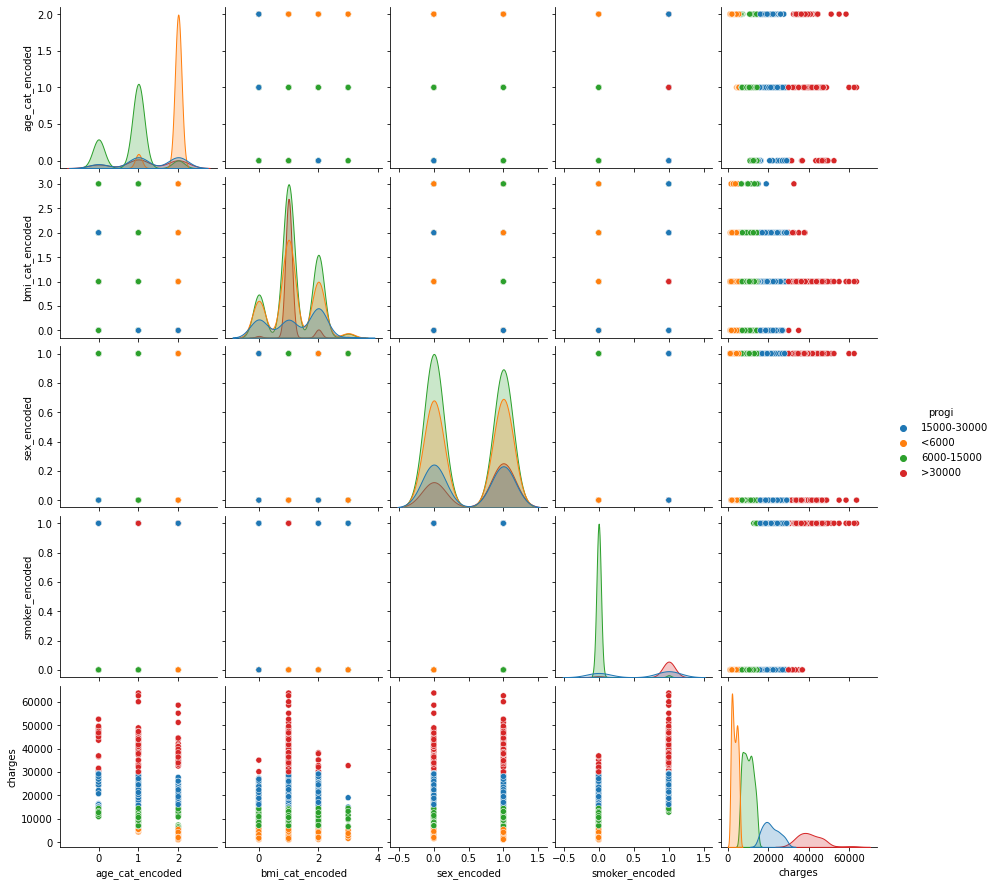

In [118]:
sns.pairplot(initial_df, vars=['age_cat_encoded','bmi_cat_encoded','sex_encoded','smoker_encoded', 'charges'], 
             hue='progi')
plt.show()

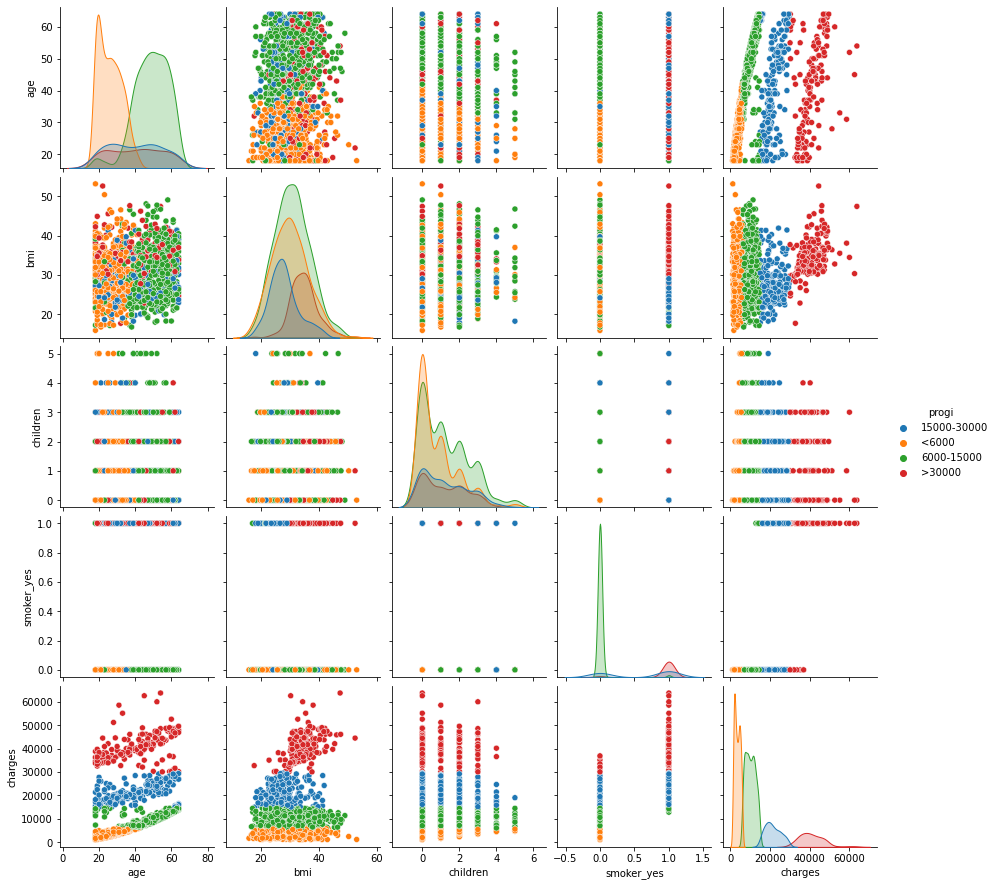

In [115]:
sns.pairplot(df, vars=['age','bmi','children','smoker_yes', 'charges'], hue='progi')
plt.show()

In [108]:
group_1 = df[df['charges'] < I_prog]
group_2 = df[df['charges'] < II_prog]
group_3 = df[df['charges'] <= III_prog]
group_4 = df[df['charges'] > III_prog]

In [109]:
group_1_initial = initial_df[df['charges'] < I_prog]
group_2_initial = initial_df[df['charges'] < II_prog]
group_3_initial = initial_df[df['charges'] <= III_prog]
group_4_initial = initial_df[df['charges'] > III_prog]

In [110]:
group_1.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,429.0,26.048951,6.331565,18.0000,18.00000,20.0000,25.00000,31.00000,35.00000,42.00000
bmi,429.0,30.035315,6.215234,15.9600,22.21100,25.8000,29.92000,34.10000,38.43200,53.13000
children,429.0,0.808858,1.083356,0.0000,0.00000,0.0000,0.00000,1.00000,2.00000,5.00000
charges,429.0,3392.999822,1390.278719,1121.8739,1645.05638,2138.0707,3279.86855,4564.19145,5357.93257,5989.52365
sex_male,429.0,0.503497,0.500572,0.0000,0.00000,0.0000,1.00000,1.00000,1.00000,1.00000
smoker_yes,429.0,0.000000,0.000000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
region_northwest,429.0,0.247086,0.431821,0.0000,0.00000,0.0000,0.00000,0.00000,1.00000,1.00000
region_southeast,429.0,0.293706,0.455991,0.0000,0.00000,0.0000,0.00000,1.00000,1.00000,1.00000
region_southwest,429.0,0.251748,0.434524,0.0000,0.00000,0.0000,0.00000,1.00000,1.00000,1.00000
obese,429.0,0.489510,0.500474,0.0000,0.00000,0.0000,0.00000,1.00000,1.00000,1.00000


In [111]:
group_1_initial.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,429.0,26.048951,6.331565,18.0000,18.00000,20.0000,25.00000,31.00000,35.00000,42.00000
bmi,429.0,30.035315,6.215234,15.9600,22.21100,25.8000,29.92000,34.10000,38.43200,53.13000
children,429.0,0.808858,1.083356,0.0000,0.00000,0.0000,0.00000,1.00000,2.00000,5.00000
charges,429.0,3392.999822,1390.278719,1121.8739,1645.05638,2138.0707,3279.86855,4564.19145,5357.93257,5989.52365
region_encoded,429.0,1.589744,1.078458,0.0000,0.00000,1.0000,2.00000,3.00000,3.00000,3.00000
bmi_cat_encoded,429.0,1.144522,0.741052,0.0000,0.00000,1.0000,1.00000,2.00000,2.00000,3.00000
age_cat_encoded,429.0,1.916084,0.277586,1.0000,2.00000,2.0000,2.00000,2.00000,2.00000,2.00000
sex_encoded,429.0,0.503497,0.500572,0.0000,0.00000,0.0000,1.00000,1.00000,1.00000,1.00000
smoker_encoded,429.0,0.000000,0.000000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000


In [114]:
group_4.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,162.0,40.376543,14.472512,18.00000,20.0000,27.000000,42.00000,52.7500,60.000000,64.00000
bmi,162.0,34.845432,4.736925,17.76500,30.2140,31.692500,34.65000,37.0275,40.884500,52.58000
children,162.0,1.166667,1.137994,0.00000,0.0000,0.000000,1.00000,2.0000,3.000000,4.00000
charges,162.0,40761.308558,6165.955587,30063.58055,33901.3425,36203.125612,39854.11165,44481.9994,47924.906135,63770.42801
sex_male,162.0,0.635802,0.482697,0.00000,0.0000,0.000000,1.00000,1.0000,1.000000,1.00000
smoker_yes,162.0,0.938272,0.241408,0.00000,1.0000,1.000000,1.00000,1.0000,1.000000,1.00000
region_northwest,162.0,0.179012,0.384551,0.00000,0.0000,0.000000,0.00000,0.0000,1.000000,1.00000
region_southeast,162.0,0.376543,0.486021,0.00000,0.0000,0.000000,0.00000,1.0000,1.000000,1.00000
region_southwest,162.0,0.228395,0.421100,0.00000,0.0000,0.000000,0.00000,0.0000,1.000000,1.00000
obese,162.0,0.919753,0.272517,0.00000,1.0000,1.000000,1.00000,1.0000,1.000000,1.00000


In [113]:
group_2_initial.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,980.0,38.845918,13.984076,18.0000,19.00000,26.000000,39.000000,51.00000,58.00000,64.000
bmi,980.0,30.492469,6.150983,15.9600,22.60900,26.101250,30.200000,34.32000,38.68150,53.130
children,980.0,1.056122,1.211923,0.0000,0.00000,0.000000,1.000000,2.00000,3.00000,5.000
charges,980.0,7112.209423,3869.930786,1121.8739,2097.57072,3701.622875,6789.108725,10411.04355,12629.23871,14988.432
region_encoded,980.0,1.529592,1.116385,0.0000,0.00000,1.000000,2.000000,3.00000,3.00000,3.000
bmi_cat_encoded,980.0,1.158163,0.712134,0.0000,0.00000,1.000000,1.000000,2.00000,2.00000,3.000
age_cat_encoded,980.0,1.303061,0.692135,0.0000,0.00000,1.000000,1.000000,2.00000,2.00000,2.000
sex_encoded,980.0,0.486735,0.500079,0.0000,0.00000,0.000000,0.000000,1.00000,1.00000,1.000
smoker_encoded,980.0,0.007143,0.084256,0.0000,0.00000,0.000000,0.000000,0.00000,0.00000,1.000
